## 1. Project Overview & Scope

This notebook documents an **exploratory clustering analysis** on wireline log data from Utah FORGE Well 56-32. The project was developed with two experimental goals:

---

### Project Intent

1. **Identify statistically distinct wellbore segments**  
   The primary motivation is to segment the well into data-driven zones that may reflect geomechanical differences, regardless of whether they match true formation boundaries. These segments will support the **next phase of the project**:  

2. **Test the potential of clustering for lithology identification**  
   Although this was not the core objective, the project investigates whether meaningful lithology-related patterns can emerge through unsupervised clustering — especially in the absence of labeled formation data.

   > **Optimizing Mechanical Specific Energy (MSE)** performance by analyzing ROP/WOB ratios in each cluster.

---

### Geological Context

- The Utah FORGE formation is known to be **geologically homogeneous**, consisting mostly of granodiorite.
- Only **3–4 petrophysical logs** (`GR_TMG`, `DTCO_MPS_R`, `TNPH`) were used for clustering, which limits the ability to differentiate subtle lithological changes.
- As such, **perfect lithology separation was not expected**, but the project remains valuable for exploring zone-based performance optimization.

---

### Reflection

> I’m glad I pursued this direction — even though the clustering didn’t align neatly with formation logs, it pushed me into deeper analysis of the data and reinforced the importance of segmentation in MSE optimization workflows.  
> The insights and tools developed here are applicable to more heterogeneous wells and can inform future well planning in similar fields.

---



## 2. Import Libraries & Setup

We import all required Python libraries and define global settings. All file paths (LAS, CSV) should be set clearly here to ensure notebook reusability.


In [2]:
import lasio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.interpolate import interp1d

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 3. Load & Preview Wireline Data 

We load the processed wireline logs (already cleaned externally) and inspect their structure. This includes checking column availability, depth range, and key logs for clustering.


In [3]:
las=lasio.read("University_of_Utah_Forge_56_32_ThrubitDipole_Aniso_analysis_result_3452-9050ft_LAS.las")
df_wireline=las.df()
df_wireline['MD']=df_wireline.index
df_wireline.reset_index(drop=True, inplace=True)

In [4]:
df_wireline.describe().T

,count,mean,std,min,25%,50%,75%,max
AZIM,11197.0,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.0000
BS_RM,11197.0,8.750000,0.000000,8.7500,8.750000,8.75000,8.750000,8.7500
C1_24,11197.0,8.867372,0.215136,8.5952,8.739300,8.79380,8.923200,10.2521
DEVI,11197.0,1.774719,0.710931,0.0000,1.271500,1.73110,2.090900,4.9656
DTCO_MPS_R,11166.0,53.974110,2.438965,46.3279,52.876625,53.65740,54.518875,86.0415
DTSH_FAST,11176.0,96.421127,5.904578,78.4969,92.776100,95.38245,98.800475,158.3739
DTSH_SLOW,11176.0,98.142091,5.883004,78.9535,94.391100,97.21325,100.590250,159.0622
FSA_ERRMINUS,11178.0,48.825640,42.921026,-17.7368,16.250250,34.17325,83.185575,174.3960
FSA_ERRPLUS,11178.0,69.340151,44.019713,3.2802,35.712875,55.25090,104.522400,197.5650
FSA_NAZ_IN,1315.0,36.533581,16.787123,2.6146,24.333300,34.75230,47.903800,112.9260


#### Note 1 

`FSA_NAZ_IN` column has 1315 non-null value out of 11197. 88% of data is missing, therefore needs to be droped. There also other columns contains null values but they will not blend the result.

In [5]:
df_wireline = df_wireline.drop(columns=['FSA_NAZ_IN'])

## 4. Load & Preview Wireline Data 5. Standardization (Scaling)

Clustering algorithms are sensitive to variable scale. We apply `StandardScaler` to ensure features like `GR`, `DTCO`, and `TNPH` are weighted equally during clustering.


In [6]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(df_wireline.dropna())
X_scaled.shape

(11154, 27)

## 5. Load & Preview Wireline Data 5. Optimal Cluster Evaluation (k Selection)

We evaluate a range of cluster numbers (k = 2 to 14) using the Elbow Method and Silhouette Score. These metrics help us determine the most meaningful segmentation of the well.


To determine the most appropriate number of clusters for unsupervised lithology segmentation, we applied two commonly used evaluation methods: the Elbow Method and the Silhouette Score.


Note : At this stage, we are exploring multiple k values (from 2 to 14), without committing to a final selection. The goal is to visually inspect these metrics and inform our decision for optimal clustering structure based on log response separability.

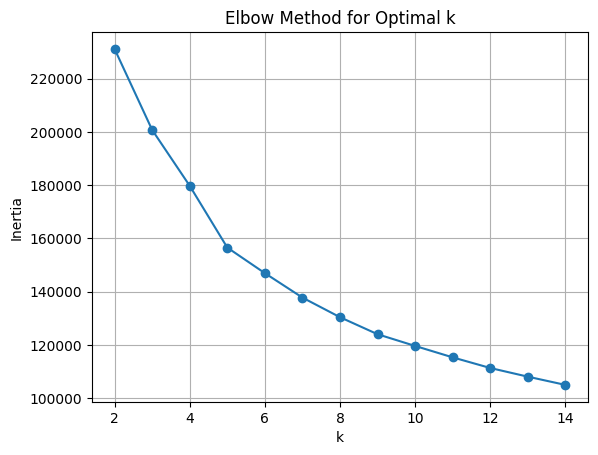

CPU times: user 1.02 s, sys: 535 ms, total: 1.56 s
Wall time: 269 ms


In [7]:
%%time
inertias = []
k_values = range(2, 15)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)  
    inertias.append(model.inertia_)

plt.plot(k_values, inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

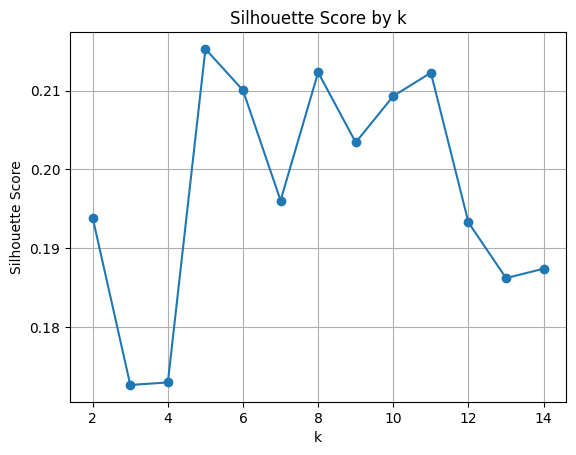

In [8]:
scores = []
for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)

plt.plot(k_values, scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by k')
plt.grid(True)
plt.show()


#### Evaluation Result:
Based on the Elbow Method and Silhouette Score analysis over k = 2 to 14, the most promising clustering configurations were observed at `5` and `8`. These two configurations were selected for further inspection and comparison in the lithology clustering analysis.

## 6. Clustering Function & Execution

We define a reusable function `perform_kmeans_clustering()` to run KMeans clustering, scale features, and return the clustered dataset. We apply it with the selected `k` values.


In [9]:
def perform_kmeans_clustering(df, features, n_clusters):
    """
    Perform KMeans clustering on selected features of a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data
    - features: list of column names to use for clustering
    - n_clusters: number of clusters to form

    Returns:
    - df_clustered: DataFrame with cluster labels added
    - model: fitted KMeans model
    - scaler: fitted StandardScaler
    """
    df_clustered = df[['MD'] + features].dropna().copy()
   
    X = df_clustered[features]
    
    scaler = StandardScaler()
    
    X_scaled = scaler.fit_transform(X)
    
    model = KMeans(n_clusters=n_clusters, random_state=42)
    
    cluster_labels = model.fit_predict(X_scaled)
    
    df_clustered['Cluster'] = cluster_labels
    
    return df_clustered, model, scaler

In [10]:
df_kmeans_3, kmeans_model_3, scaler_3 = perform_kmeans_clustering(
    df=df_wireline,
    features=['GR_TMG', 'DTCO_MPS_R', 'TNPH'],
    n_clusters=8
)
df_kmeans_3 = df_kmeans_3.reset_index(drop=True)

## 7. Exploring Cluster Characteristics

After applying KMeans clustering, the resulting DataFrame (`df_kmeans_3`) includes a `"Cluster"` column indicating the assigned cluster for each row based on log responses.

To interpret and compare the behavior of each cluster, you can use the **`groupby()`** method in pandas. This allows you to calculate **summary statistics per cluster**.

Here are some common examples:

-  **Mean values per cluster**:
  ```python
  df_kmeans_3.groupby("Cluster")[["GR_TMG", "DTCO_MPS_R", "TNPH"]].mean()
  df_kmeans_3.groupby("Cluster")[["GR_TMG", "DTCO_MPS_R", "TNPH"]].median()
  df_kmeans_3.groupby("Cluster")[["GR_TMG", "DTCO_MPS_R", "TNPH"]].std()

In [11]:
features = ['GR_TMG', 'DTCO_MPS_R', 'TNPH']

summary_stats = df_kmeans_3.groupby('Cluster')[features].describe().round(2)
cluster_means = df_kmeans_3.groupby('Cluster')[features].mean().round(2)
summary_stats


GR_TMG                                                         \
          count    mean    std     min     25%     50%     75%     max   
Cluster                                                                  
0        2076.0  210.84  26.55  125.16  191.19  213.33  232.76  265.33   
1         952.0  171.01  42.24   59.28  144.82  166.07  193.11  333.16   
2         128.0  150.47  44.19   30.46  127.78  157.43  181.32  257.23   
3        2460.0   86.14  27.09    6.60   67.38   87.64  104.48  150.22   
4         300.0  106.67  44.58   34.82   69.18  101.43  142.08  278.24   
5        2111.0  163.91  25.40   59.58  147.89  164.48  179.04  319.06   
6        2046.0  288.75  34.96  238.02  263.25  278.71  305.55  459.18   
7        1093.0   77.80  23.06   36.17   61.95   71.89   89.14  214.76   

        DTCO_MPS_R                                                    TNPH  \
             count   mean   std    min    25%    50%    75%    max   count   
Cluster                                                                      
0           2076.0  53.92  0.81  51.32  53.39  53.81  54.38  57.08  2076.0   
1            952.0  55.96  1.33  53.35  55.03  55.78  56.65  61.17   952.0   
2            128.0  68.88  4.54  63.73  65.94  67.42  70.91  86.04   128.0   
3           2460.0  53.35  1.11  48.04  52.73  53.46  54.05  56.95  2460.0   
4            300.0  59.38  2.52  54.83  57.24  59.10  61.14  65.20   300.0   
5           2111.0  52.20  1.15  46.33  51.77  52.34  52.95  54.22  2111.0   
6           2046.0  53.94  1.09  49.15  53.34  53.81  54.36  58.84  2046.0   
7           1093.0  53.99  1.38  47.87  53.16  54.05  54.96  57.48  1093.0   

                                                   
         mean   std   min   25%   50%   75%   max  
Cluster                                            
0        0.02  0.01 -0.00  0.02  0.03  0.03  0.06  
1        0.06  0.02  0.01  0.05  0.06  0.07  0.12  
2        0.19  0.03  0.10  0.17  0.18  0.20  0.30  
3        0.05  0.02 -0.00  0.03  0.05  0.06  0.08  
4        0.14  0.04  0.08  0.11  0.13  0.16  0.25  
5        0.03  0.01  0.00  0.03  0.03  0.04  0.09  
6        0.02  0.01 -0.01  0.00  0.01  0.02  0.10  
7        0.10  0.02  0.07  0.08  0.10  0.11  0.21

## 8. Visualizing Cluster Behavior Over Depth

The plots below show how each input feature used in clustering (`GR_TMG`, `DTCO_MPS_R`, `TNPH`) varies with depth, colored by the assigned cluster.

Each scatterplot uses:
- **Y-axis:** Measured Depth (`MD`), inverted to mimic a typical well log view (top to bottom)
- **X-axis:** One of the clustering features

These plots help us answer important questions:
- Are certain clusters confined to specific depth intervals?
- Do clusters follow consistent trends in gamma ray, sonic, or porosity responses?
- Are there abrupt transitions between clusters that suggest data-driven formation boundaries?

### Subplot Descriptions:
- **GR_TMG vs Depth:**  
  Shows radioactive response (typically higher in shales). Helps identify clean vs. clay-rich zones.
  
- **DTCO_MPS_R vs Depth:**  
  Sonic travel time — can distinguish compact rocks from porous or fractured ones. Useful for mechanical contrast.

- **TNPH vs Depth:**  
  Neutron porosity — highlights relative porosity differences. Often correlates with fluid content or formation type.

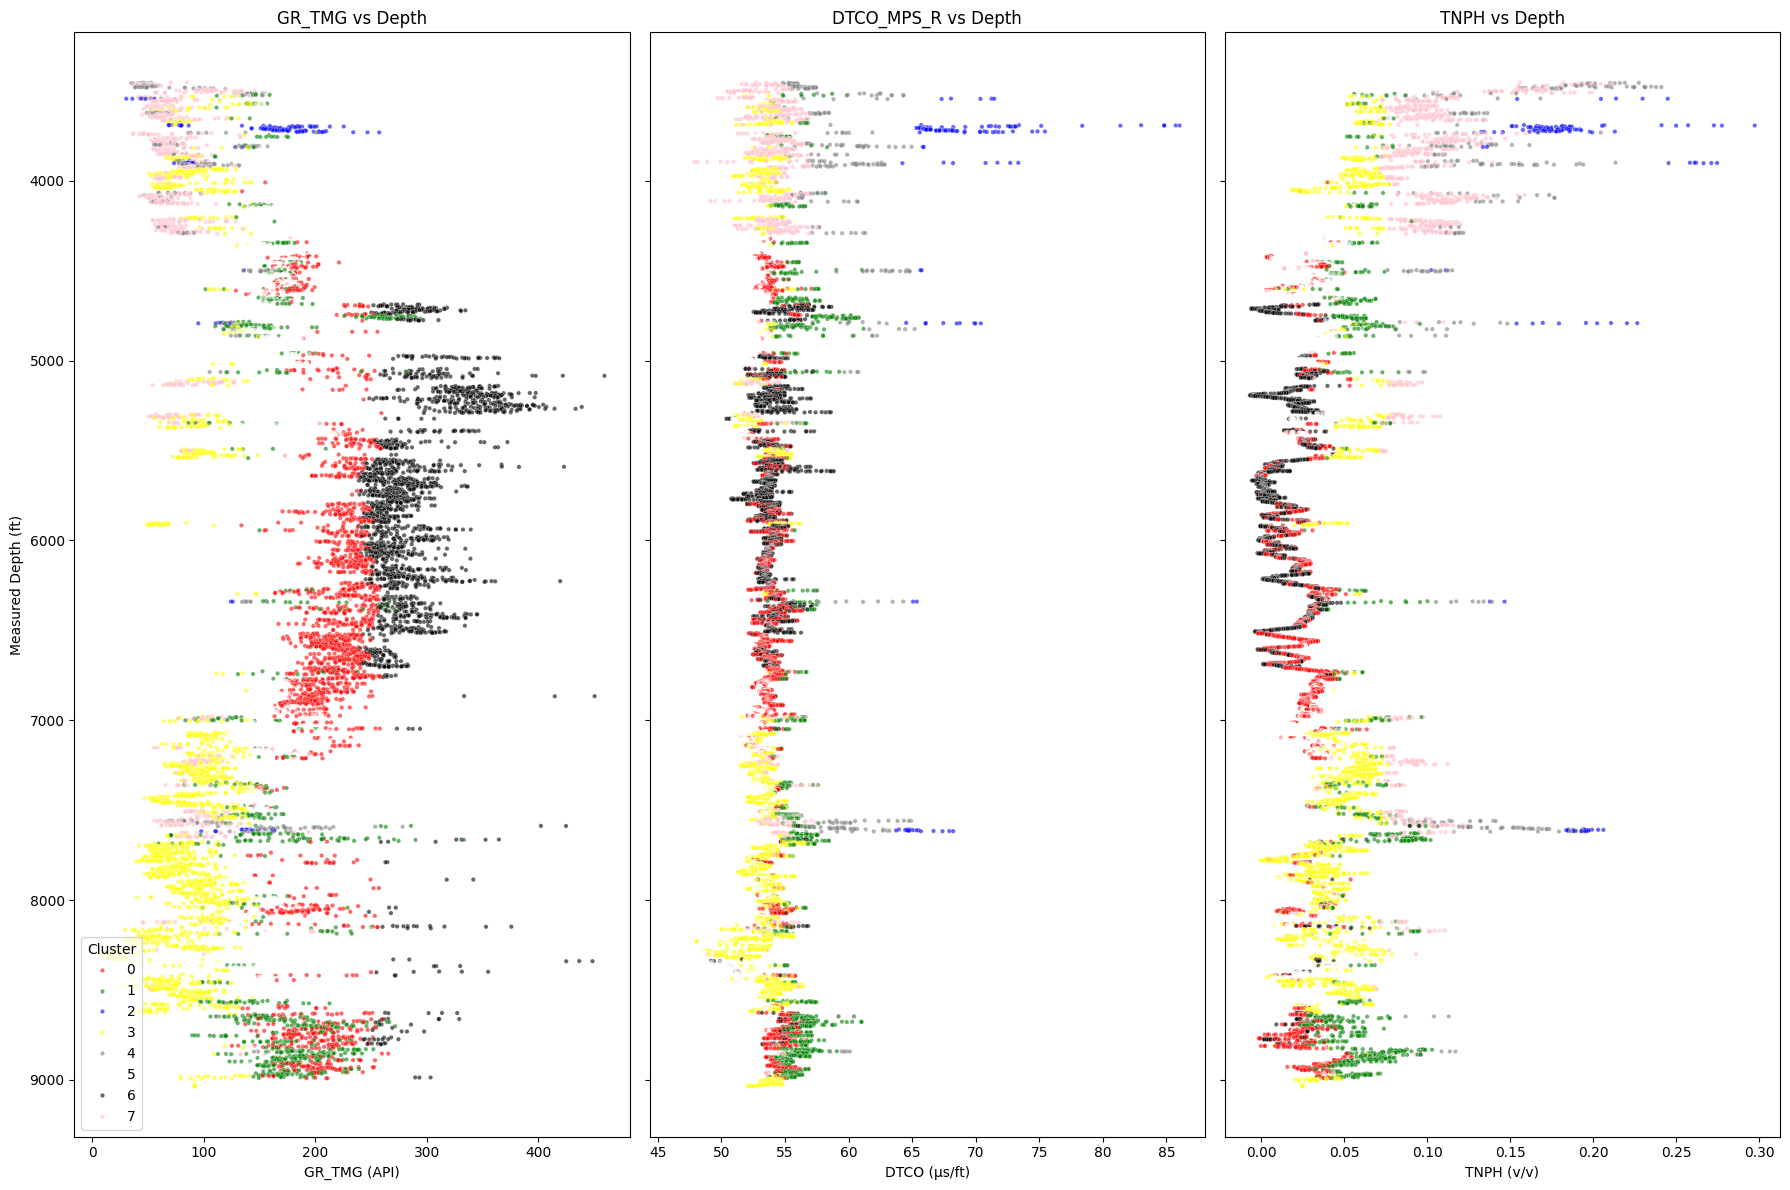

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 12), sharey=True)
palette = {0: 'red', 1: 'green', 2: 'blue', 3:'yellow', 4:'grey', 5:"white",6:"black", 7:"pink"}


# GR_TMG vs Depth
sns.scatterplot(
    data=df_kmeans_3,
    x='GR_TMG',
    y='MD',
    hue='Cluster',
    palette=palette,
    s=10,
    alpha=0.6,
    ax=axes[0]
)
axes[0].invert_yaxis()
axes[0].set_xlabel("GR_TMG (API)")
axes[0].set_ylabel("Measured Depth (ft)")
axes[0].set_title("GR_TMG vs Depth")

# DTCO_MPS_R vs Depth
sns.scatterplot(
    data=df_kmeans_3,
    x='DTCO_MPS_R',
    y='MD',
    hue='Cluster',
    palette=palette,
    s=10,
    alpha=0.6,
    ax=axes[1]
)
axes[1].invert_yaxis()
axes[1].set_xlabel("DTCO (μs/ft)")
axes[1].set_title("DTCO_MPS_R vs Depth")

# TNPH vs Depth
sns.scatterplot(
    data=df_kmeans_3,
    x='TNPH',
    y='MD',
    hue='Cluster',
    palette=palette,
    s=10,
    alpha=0.6,
    ax=axes[2]
)
axes[2].invert_yaxis()
axes[2].set_xlabel("TNPH (v/v)")
axes[2].set_title("TNPH vs Depth")

axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[0].legend(title="Cluster", loc="lower left")

plt.tight_layout()
plt.show()


## 9. Optional: Further Calibration with XRD Mineralogy Data

In this optional section, we incorporate **XRD (X-Ray Diffraction)** mineral data into our clustering workflow. While clustering was performed using only wireline logs, the interpolated XRD results help us **calibrate or interpret cluster compositions more geologically**.

This step is **not required** for MSE optimization, but it offers useful insights if you're interested in:
- Understanding the **mineral makeup** of each cluster
- Naming clusters based on **real lithological indicators**
- Improving lithology recognition in future wells with similar data

### Step 1: Import and Linearize the XRD Data

XRD samples are often reported as intervals (e.g., 4400–4410 ft), but we need mineral percentages **at a single depth** to interpolate them onto wireline logs.

To prepare the data:
- We "linearize" each sample interval into 1-ft increments.
- Each 10-ft XRD interval is converted to 10 rows — one per foot.
- This increases depth resolution and makes it compatible with clustering results (`df_kmeans_3['MD']`).

Python makes this transformation efficient by looping through each row and expanding the depth range, creating a long-form DataFrame with continuous 1-ft spacing.


In [49]:
df_xrd=pd.read_csv("56-32 XRD Results_v2.csv")
df_xrd=df_xrd.rename(columns={"Unnamed: 0":"From (ft)",
                       "Unnamed: 1":"To (ft)"})

In [50]:
expanded_rows = []

for _, row in df_xrd.iterrows():
    for depth in range(int(row['From (ft)']), int(row['To (ft)'])):
        new_row = row.drop(labels=['From (ft)', 'To (ft)']).to_dict()
        new_row['Depth (ft)'] = depth
        expanded_rows.append(new_row)

df_xrd_linear = pd.DataFrame(expanded_rows)
df_xrd_linear.rename(columns={"Depth (ft)":"MD"}, inplace=True)

In [51]:
print(f"Wireline Data (MD):    min: {df_kmeans_3['MD'].min()}, max:{df_xrd_linear['MD'].max()}")
print(f"XRD Data (MD):    min: {df_xrd_linear['MD'].min()}, max:{df_xrd_linear['MD'].max()}")

Wireline Data (MD):    min: 3454.0, max:9129
XRD Data (MD):    min: 3050, max:9129


### Step 2: Clean and Convert Mineral Data

Some XRD values are reported as `'tr'` (trace amounts) or left blank. These must be handled before numerical operations.

To ensure proper interpolation:
- We convert all mineral columns from `object` to `float`
- Non-numeric values are safely replaced with `NaN`
- We optionally filter out minerals with very sparse data (e.g., fewer than 500 valid samples)

This cleaning ensures that only reliable mineral columns are carried forward to the interpolation step.


In [52]:
df_xrd_linear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Quartz         690 non-null    int64  
 1   Plagioclase    690 non-null    int64  
 2   K-feldspar     690 non-null    int64  
 3   Biotite        690 non-null    object 
 4   Hornblende     640 non-null    object 
 5   Clinopyroxene  500 non-null    object 
 6   Titanite       550 non-null    object 
 7   Magnetite      450 non-null    object 
 8   Anhydrite      30 non-null     object 
 9   Calcite        670 non-null    object 
 10  Siderite       60 non-null     object 
 11  Dolomite       60 non-null     object 
 12  Illite         640 non-null    object 
 13  chlorite       510 non-null    object 
 14  Muscovite      10 non-null     object 
 15  Epidote        20 non-null     float64
 16  kaolinite      40 non-null     float64
 17  Diopside       70 non-null     float64
 18  Scapolite 

In [53]:
use_cols=[]
for col in df_xrd_linear.columns:
    if df_xrd_linear[col].count()<500:
        df_xrd_linear.drop(columns=col, inplace=True)        
df_xrd_linear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Quartz         690 non-null    int64 
 1   Plagioclase    690 non-null    int64 
 2   K-feldspar     690 non-null    int64 
 3   Biotite        690 non-null    object
 4   Hornblende     640 non-null    object
 5   Clinopyroxene  500 non-null    object
 6   Titanite       550 non-null    object
 7   Calcite        670 non-null    object
 8   Illite         640 non-null    object
 9   chlorite       510 non-null    object
 10  MD             690 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 59.4+ KB


###  Step 3: Interpolate Mineral Data onto Wireline Depth

We now align mineralogy data with our clustered DataFrame (`df_kmeans_3`) by interpolating each mineral column onto the `"MD"` depth column.

- This gives us `Quartz_interp`, `Plagioclase_interp`, etc.
- For each depth in the clustered logs, we now estimate the mineral content based on lab data
- This enables **per-cluster mineral profiling** for interpretation or lithology labeling

Python's `scipy.interpolate.interp1d()` method enables this transformation precisely, even when the original XRD data is sparse and unevenly spaced.


In [54]:
# Convert all object-type columns to numeric (e.g., 'tr' → NaN)
for col in df_xrd_linear.select_dtypes(include='object').columns:
    df_xrd_linear[col] = pd.to_numeric(df_xrd_linear[col], errors='coerce')

# Define minerals to interpolate
minerals_to_interp = [
    'Quartz', 'Plagioclase', 'K-feldspar', 'Biotite',
    'Hornblende', 'Calcite', 'Illite', 'chlorite'
]

# Sort df_kmeans_3 by depth
df_kmeans_3 = df_kmeans_3.sort_values("MD").reset_index(drop=True)

# Interpolate each mineral
for mineral in minerals_to_interp:
    valid = df_xrd_linear[['MD', mineral]].dropna()
    if not valid.empty:
        interp_func = interp1d(
            valid['MD'], valid[mineral],
            bounds_error=False, fill_value=np.nan
        )
        df_kmeans_3[mineral + '_interp'] = interp_func(df_kmeans_3['MD'])
    else:
        df_kmeans_3[mineral + '_interp'] = np.nan


###  Step 4: Analyze Mineral Distribution by Cluster

Now that mineralogy is aligned with clusters, we can:
- Compute average mineral composition per cluster
- Compare clusters in terms of silica, feldspar, biotite, clay content, etc.
- Make informed guesses about each cluster's dominant rock type (e.g., granodiorite vs. altered zone)

This cross-comparison is not perfect — but it enhances interpretability and illustrates how **domain knowledge and data science can complement each other.**


In [56]:
df_kmeans_3.groupby('Cluster')[["GR_TMG","DTCO_MPS_R","TNPH"]].std().round(2)

,GR_TMG,DTCO_MPS_R,TNPH
Cluster,,,
0,38.67,1.28,0.01
1,26.82,1.39,0.02
2,42.05,4.70,0.04
3,25.62,1.38,0.01
4,44.61,2.10,0.03


In [59]:
df_kmeans_3.groupby('Cluster')[mineral_cols].mean().round(3)

,Quartz_interp,Plagioclase_interp,K-feldspar_interp,Biotite_interp,Hornblende_interp,Calcite_interp,Illite_interp,chlorite_interp
Cluster,,,,,,,,
0,19.366,44.766,28.681,2.737,2.772,9.365,1.414,1.513
1,12.900,46.858,12.860,5.935,7.724,19.250,2.353,2.199
2,8.575,56.099,19.353,5.311,2.765,2.270,2.385,4.133
3,11.036,47.831,26.596,4.474,4.414,13.183,1.694,2.047
4,12.286,49.446,19.299,6.206,4.650,5.102,2.230,3.509


In [60]:
df_kmeans_3.groupby('Cluster')[mineral_cols].median().round(3)

,Quartz_interp,Plagioclase_interp,K-feldspar_interp,Biotite_interp,Hornblende_interp,Calcite_interp,Illite_interp,chlorite_interp
Cluster,,,,,,,,
0,19.148,45.000,30.484,2.000,2.000,1.715,1.000,1.366
1,11.000,51.907,8.758,5.907,6.761,12.127,2.000,2.315
2,4.354,52.223,13.000,6.218,3.000,2.147,1.948,2.882
3,6.044,49.275,30.907,2.747,2.000,1.930,1.489,1.938
4,5.099,51.242,16.700,5.841,3.613,1.999,1.728,2.677


In [62]:
df_kmeans_3.groupby('Cluster')[mineral_cols].std().round(3)


,Quartz_interp,Plagioclase_interp,K-feldspar_interp,Biotite_interp,Hornblende_interp,Calcite_interp,Illite_interp,chlorite_interp
Cluster,,,,,,,,
0,5.760,5.583,6.492,2.570,1.962,14.652,0.694,0.659
1,11.224,16.319,10.049,3.404,5.329,19.576,1.143,0.980
2,8.626,12.252,11.518,2.235,1.251,0.361,1.706,3.307
3,9.704,9.468,13.172,4.068,4.377,17.657,0.874,0.714
4,14.081,13.749,11.220,3.771,3.677,8.698,1.600,2.386
